In [14]:
import os
import sys
import pandas as pd
sys.path.insert(0, os.path.abspath('../lib'))

import config
from evaluate import get_results, get_results_multiclass, compute_plot_roc_multiclass, evaluate_model_aggregated

from sklearn.utils import shuffle, class_weight
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd

# Task 2: Mosquito Species Classification (MSC)
This code is complementary to the paper: HumBugDB: a large-scale acoustic mosquito dataset. Section B of `/docs/` gives detail on the meaning of the metadata fields that are present in the `csv` file `config.data_df`, while Section C describes in more detail the models used here as baselines.


This notebook provides the interface to partition data, extract features, train a BNN model in either PyTorch or Keras and evaluate its accuracy, precision-recall, confusion matrices and uncertainty metrics. Settings are specified in `config.py` and `config_pytorch.py` or `config_keras.py` which are located in `../lib`. Functions are imported from data and feature processing code in `../lib/feat_util.py`, model training in `../lib/runTorchMultiClass.py` or `../lib/runKeras.py` and evaluation in `../lib/evaluate.py`.

### Data and feature configuration `config.py`
Specify the metadata (csv) location in `data_df`, with the location of the raw wave files in `data_dir`. The desired output for the features is set by `dir_out`. Model objects will be saved to `../models/PyTorch/` for PyTorch, or `../models/keras/` for Keras models.

#### Feat A
Feat A:  features extracted for [VGGish](https://github.com/harritaylor/torchvggish)'s model class, imported from `feat_vggish.py`. Edits can be made in `lib/PyTorch/vggish/{mel_features.py, vggish_input.py, vggish_params.py}`. A further discussion on feature transformations is given in Section B.3 of the [HumBugDB supplement](https://github.com/HumBug-Mosquito/HumBugDB/blob/devel/docs/NeurIPS_2021_HumBugDB_Supplement.pdf).


#### Feat B
Feat B uses log-mel features with `librosa`, configurable in `config.py` with the sample rate `rate`, to which data is re-sampled on loading, a window size `win_size` which determines the size of a training window (in number of _feature_ windows), `step_size`, which determines the step size taken by the window, `NFFT`, and `n_hop`, which are parameters for the core STFT transform upon which log-mel feature extraction is based. Finally, `n_feat` determines the number of mel-frequency bands.

In `librosa`, we can calculate the value of `win_size` to achieve a user's desired `duration` for a label as follows:

`win_size` = `duration` / `frame_duration`, where `frame_duration` = `n_hop`/`rate`. Librosa uses a default `hop_length` of `NFFT/4`.
The default values in `config.py` are optimised for `rate` = 8000 with  `win_size` = 30, `NFFT` = 2048, `n_hop` = `default`,  to achieve a label duration of $30 \times 2048/(4\times 8000) = 1.92$ (s).

## Step 1: Choose Keras or PyTorch


In [3]:
library = 'PyTorch'

if library == 'PyTorch':
    from PyTorch.runTorchMultiClass import train_model, load_model, evaluate_model, ResnetDropoutFull, Resnet, VGGishDropout
    from PyTorch import config_pytorch
elif library == 'Keras':
    from tensorflow import keras
    from Keras.runKeras import train_model, load_model, evaluate_model
else:
    print('Library:', library, 'not supported. Please add your own code for support of that framework.')

## Step 2: Data selection for classification

In [4]:
# Select IHI Tanzania cup data to use for multi-species classification

df = pd.read_csv(config.data_df)
idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_all = df[idx_multiclass]

In [5]:
# Select list of classes with sufficient samples for significant analysis. Ordered with similar groups in adjacent classes.

classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus']

In [6]:
feat_type = 'FeatB'

if feat_type == 'FeatA': #VGGish features (Feat. A)
    from feat_vggish import get_train_test_multispecies, reshape_feat    
elif feat_type == 'FeatB': #log-mel-128 win 30 step 5 train, step 30 test, features (Feat. B)
    from feat_util import get_train_test_multispecies, reshape_feat
else:
    print('Features:', feat_type, 'not defined. Please check spelling or add your own code for support of those features.')

In [7]:
# Extract feats, expected runtime ~14 mins train, ~5mins test if pickle does not exist yet.
random_seed = 10
X_train, y_train, X_test, y_test = get_train_test_multispecies(df_all, classes, random_seed)

## Step 3: Model definition and training

In [ ]:
if feat_type == 'FeatA':
    X_train_CNN, y_train_CNN = reshape_feat(X_train, y_train)
elif feat_type == 'FeatB':
    X_train_CNN, y_train_CNN = reshape_feat(X_train, y_train, config.win_size, config.step_size)

In [ ]:
# Keras training code
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train_CNN)),y=np.array(y_train_CNN))
model = train_model(X_train_CNN, y_train_CNN, class_weight = class_weights)

In [ ]:
# PyTorch training code, only difference is specification of model object.
# Choose from {ResnetDropoutFull, Resnet, VGGishDropout} as defined in runTorchMulticlass.py
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train)),y=np.array(y_train))
model = train_model(X_train_CNN, y_train_CNN, class_weight = class_weights, model = ResnetDropoutFull(n_classes = 8, dropout=0.2))

### Load model from checkpoint (optional)

In [9]:
# Example code to load PyTorch model. Select from {ResnetDropoutFull, Resnet, VGGishDropout} as defined in runTorchMultiClass.py
filepath = '../outputs/models/pytorch/'
model_name = 'model_e17_2021_09_01_21_45_45.pth'
model = load_model(filepath + model_name, model=ResnetDropoutFull(n_classes=8, dropout=0.05))

Training on cuda:0


In [16]:
# Example code to load Keras model

filepath = '../outputs/models/keras/'
model_name = 'Win_30_Stride_5_2021_07_26_12_59_05-e80accuracy0.9635.hdf5'

model = load_model(filepath + model_name)

## Step 4: Model evaluation

Evaluating on cuda:0
BNN
{0: 0.8713000675190032, 1: 0.8514066715471603, 2: 0.9822313508754186, 3: 0.7487820513651525, 4: 0.8993444384332087, 5: 0.912752771560174, 6: 0.8855342185602326, 7: 0.8939512167244386, 'micro': 0.9027925192710023}


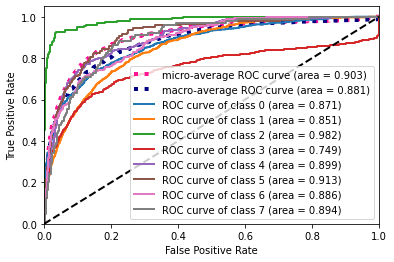

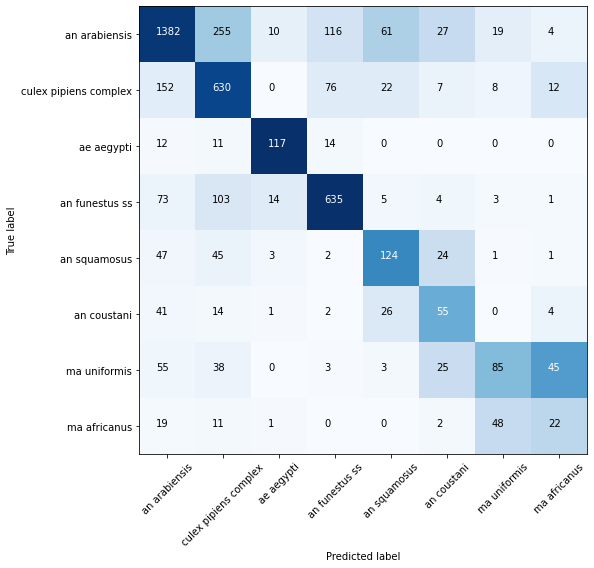

In [11]:
if feat_type == 'FeatA':
    p,y,yt = evaluate_model_aggregated(model, X_test, y_test, 30)  # Aggregate windows from feature list (0.96->1.92 s)
    get_results_multiclass(yt, p, feat_type + '_seed_' + str(random_seed) +
                                     '_'+ model_name, classes)
elif feat_type == 'FeatB':
    X_test_CNN, y_test_CNN = reshape_feat(X_test, y_test, config.win_size, config.win_size)
    preds_list = evaluate_model(model, X_test_CNN, y_test_CNN, 100)  # Predict directly over feature windows (1.92 s)
    get_results_multiclass(y_test_CNN, np.mean(preds_list,axis=0), feat_type + '_seed_' + str(random_seed) +
                                     '_'+ model_name, classes)
else:
    'Feature type not supported.'